# v1 embedding model

* v1 reproducing constrastive loss for metric learning; (2N, H, W, 3)
* v1.5 vectorising that model (B, 2N, H, W, 3)

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'jax'
import keras

In [2]:
import jax.numpy as jnp
import jax
from jax import jit, value_and_grad, vmap

import optax

from keras.layers import Input, Dense, Conv2D, GlobalMaxPooling2D
from keras.layers import Layer, BatchNormalization, Activation
from keras.models import Model

import numpy as np

print('keras', keras.__version__, 
      'jax', jax.__version__, 
      'optax', optax.__version__)

keras 3.5.0 jax 0.4.33 optax 0.2.3


In [3]:
class Opts:
    height_width = 64
    batch_size = 4          # B (outer batch size, used for v1.5)
    num_classes = 6         # C total number of classes
    num_egs_per_class = 3   # N number of examples per class
    embedding_dim = 64      # E embedding dim
    learning_rate = 1e-4
    
opts = Opts()

def shapes(debug_str, list_of_variables):
    return f"{debug_str} {[v.shape for v in list_of_variables]}"

In [4]:
# plotting debug

from PIL import Image

def collage(pil_imgs, rows, cols):
    n = len(pil_imgs) 
    if n != rows * cols:
        raise Exception()
    img_h, img_w = pil_imgs[0].size    
    collage = Image.new('RGB', (rows*img_h, cols*img_w))
    for i in range(n):
        pr, pc = i%rows, i//rows
        collage.paste(pil_imgs[i], (pr*img_h, pc*img_w))
    return collage
    
def to_pil_img(a):
    return Image.fromarray(np.array(a))

In [5]:
from data import ConstrastiveExamples

# start with simple case of x1 R, G, B example
c_egs = ConstrastiveExamples(
    root_dir='data/reference_egs',
    obj_ids=["061", # "135","182",  # x1 red
             "111", # "153","198",  # x1 green
             "000", # "017","019"   # x2 blue
            ]
)
ds = c_egs.dataset(batch_size=opts.batch_size,
                   objs_per_batch=opts.num_egs_per_class)
for x, y in ds:
    break

x = jnp.array(x)
print(x.shape, y)

self.label_idx_to_str {0: '061', 1: '111', 2: '000'}


2024-10-19 15:34:20.759799: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(4, 6, 64, 64, 3) tf.Tensor(
[[0 0 2 2 1 1]
 [0 0 1 1 2 2]
 [1 1 0 0 2 2]
 [0 0 2 2 1 1]], shape=(4, 6), dtype=int64)


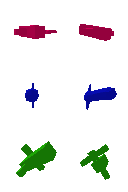

In [6]:
# recall each element of outer batch is xN examples of anchor/positive pairs

pil_imgs = list(map(to_pil_img, x[0]))
collage(pil_imgs, 2, 3)

model is simple enough embedding model

output is L2 normalised embedding ( so dot products can be used for sims and xent contrastive )

In [7]:
def conv_bn_relu(filters, y):
    y = Conv2D(filters=filters, strides=2, kernel_size=3, activation=None, padding='same')(y)
    y = BatchNormalization()(y)
    return Activation('relu')(y)

class L2Normalisation(Layer):
    def call(self, x):
        norm = jnp.linalg.norm(x, axis=-1, keepdims=True)
        return x / norm

def construct_embedding_model():
    input = Input((opts.height_width, opts.height_width, 3))
    y = conv_bn_relu(filters=16, y=input)
    y = conv_bn_relu(filters=32, y=y)
    y = conv_bn_relu(filters=64, y=y)
    y = conv_bn_relu(filters=128, y=y)
    y = GlobalMaxPooling2D()(y)  # (B, E)

    # embed, with normalisation
    embeddings = Dense(
        opts.embedding_dim,
        use_bias=False,
        kernel_initializer=keras.initializers.TruncatedNormal(),
        name='embeddings')(y)  # (B, E)
    embeddings = L2Normalisation()(embeddings)
    
    return Model(input, embeddings)    

embedding_model = construct_embedding_model()
embedding_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (Dense)              │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalisation                │ (None, 64)             │             0 │
│ (L2Normalisation)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,592 (416.38 KB)

 Trainable params: 106,112 (414.50 KB)

 Non-trainable params: 480 (1.88 KB)

In [8]:

# params, nt_params, [ntp.shape for ntp in nt_params]

In [9]:
# print("x[0]", x[0].shape)
# embeddings = embedding_model(x[0])
# embeddings.shape, jnp.linalg.norm(embeddings, axis=1)

x[0] (6, 64, 64, 3)


((6, 64),
 Array([1.        , 0.99999994, 1.        , 1.0000001 , 1.        ,
        1.        ], dtype=float32))

In [11]:
# the model sees "a batch" as the set of (anchor, positive) pairs
# whereas x is a batch of these.

params = embedding_model.trainable_variables
nt_params = embedding_model.non_trainable_variables

embeddings, nt_params_2 = embedding_model.stateless_call(params, nt_params, x[0], training=True)

print("e shape", embeddings.shape)
print("e norms", jnp.linalg.norm(embeddings, axis=-1))
print(shapes('ntps', nt_params_2))

e shape (6, 64)
e norms [1.0000001  1.         1.0000001  1.         1.         0.99999994]
ntps [(16,), (16,), (32,), (32,), (64,), (64,), (128,), (128,)]


In [12]:
# define the constrastive loss based on the 'batch' of 2N examples ( N pairs )

def main_diagonal_softmax_cross_entropy(logits):
    # cross entropy assuming "labels" are just (0, 1, 2, ...) i.e. where
    # one_hot mask for log_softmax ends up just being the main diagonal
    return -jnp.sum(jnp.diag(jax.nn.log_softmax(logits)))
    
def constrastive_loss(params, nt_params, x):
    embeddings, nt_params = embedding_model.stateless_call(params, nt_params, x, training=True)
    embeddings = embeddings.reshape((opts.num_egs_per_class, 2, opts.embedding_dim))
    anchors = embeddings[:, 0]
    positives = embeddings[:, 1]
#    print('anchors', anchors.shape, 'positives', positives.shape)
    gram_ish_matrix = jnp.einsum('ae,be->ab', anchors, positives)
    xent = main_diagonal_softmax_cross_entropy(logits=gram_ish_matrix)
    return jnp.mean(xent), nt_params

loss, nt_params_2 = constrastive_loss(params, nt_params, x[0])
print('loss', loss)
print(shapes('ntps', nt_params_2))

loss 3.2589033
ntps [(16,), (16,), (32,), (32,), (64,), (64,), (128,), (128,)]


In [13]:
# define gradients and a simple training loop

def calculate_gradients(params, nt_params, x):
    # x (2C,H,W,3)
    grad_fn = value_and_grad(constrastive_loss, has_aux=True)    
    (loss, nt_params), grads = grad_fn(params, nt_params, x)
    return (loss, nt_params), grads

opt = optax.adam(learning_rate=opts.learning_rate)

def train_step(params, nt_params, opt_state, x):
    (loss, nt_params), grads = calculate_gradients(params, nt_params, x)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, nt_params, opt_state, loss

embedding_model = construct_embedding_model()

params = embedding_model.trainable_variables
nt_params = embedding_model.non_trainable_variables
opt_state = opt.init(params)

for e in range(1000):
    params, nt_params, opt_state, loss = jit(train_step)(params, nt_params, opt_state, x[0])
    if e % 100 == 0:
        print(loss)


3.288289
1.1072654
1.1069496
1.1069436
1.1069434
1.1069435
1.1069435
1.1069435
1.1069435
1.1069435


In [15]:
# test against batch

embeddings, _ = embedding_model.stateless_call(params, nt_params, x[0], training=False)
embeddings.shape

# looks good (0,1) (2,3) (4,5) all pair well ( and others are -0.5 )

jnp.around(jnp.dot(embeddings, embeddings.T), 2)

Array([[ 1. ,  1. , -0.5, -0.5, -0.5, -0.5],
       [ 1. ,  1. , -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5,  1. ,  1. , -0.5, -0.5],
       [-0.5, -0.5,  1. ,  1. , -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5,  1. ,  1. ],
       [-0.5, -0.5, -0.5, -0.5,  1. ,  1. ]], dtype=float32)

next we get things working on a batch of these examples

In [16]:
# to use the model batched we vmap it first 

def training_call(x):
    return embedding_model.stateless_call(params, nt_params, x, training=True)

training_call = vmap(training_call)
embeddings, nt_params_2 = training_call(x)

print("e shape", embeddings.shape)
print("e norms", jnp.linalg.norm(embeddings, axis=-1))
print(shapes('ntps', nt_params_2))

2024-10-19 15:36:32.040850: E external/xla/xla/service/hlo_lexer.cc:438] Failed to parse int literal: 62981654126569403251960


e shape (4, 6, 64)
e norms [[1.         0.99999994 1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.        ]
 [0.99999994 1.         1.         1.         1.         1.        ]
 [1.         1.         1.0000001  1.         1.0000001  1.        ]]
ntps [(4, 16), (4, 16), (4, 32), (4, 32), (4, 64), (4, 64), (4, 128), (4, 128)]


In [18]:
# but note that the nt_params returned have been vectorised too
# i.e. they are [(B, p1), (B, p2), ...] instead of [(p1,), (p2,), ...]
# so, we need to aggreate them,

nt_params_2 = [jnp.mean(p, axis=0) for p in nt_params_2]
print(shapes('ntps', nt_params_2))

ntps [(), (), (), (), (), (), (), ()]


In [21]:
# as before we can vectorise the loss 
# takes (B, 2C, H, W, 3)
constrastive_loss_v = vmap(constrastive_loss, in_axes=[None, None, 0])

# and run over all of x 
loss_v, nt_params_2 = constrastive_loss_v(params, nt_params, x)  # (N)

print("before inner batch aggregation...")
print('loss_v', loss_v)
print(shapes('ntps', nt_params_2))

loss = jnp.mean(loss_v)
nt_params_2 = [jnp.mean(p, axis=0) for p in nt_params_2]

print("after inner batch aggregation...")
print('loss', loss)
print(shapes('ntps', nt_params_2))

before inner batch aggregation...
loss_v [1.1069435 2.8647838 3.1776733 2.8065224]
ntps [(4, 16), (4, 16), (4, 32), (4, 32), (4, 64), (4, 64), (4, 128), (4, 128)]
after inner batch aggregation...
loss 2.4889808
ntps [(16,), (16,), (32,), (32,), (64,), (64,), (128,), (128,)]


In [22]:
# we can calculate grads just as before but we must call a function that includes the loss 
# aggregation ( i.e. grads only are applicable for a scalar loss ) so wrap the vmap
# and jnp.mean in one function.

def constrastive_loss_v(params, nt_params, x):
    # vectorise function as normal
    loss_fn_v = vmap(constrastive_loss, in_axes=[None, None, 0])
    # call returning vectorised result
    loss_v, nt_params_v = loss_fn_v(params, nt_params, x)
    # aggregate mean over both loss and nt_params for return
    # TODO: what does this do for rng seeds?
    loss = jnp.mean(loss_v)
    nt_params = [jnp.mean(p, axis=0) for p in nt_params_v]    
    return loss, nt_params

(loss, nt_params_2), grads = jit(value_and_grad(constrastive_loss_v, has_aux=True))(params, nt_params, x)

print('loss', loss)
print(shapes('grads', grads))
print(shapes('ntps', nt_params_2))


loss 2.4890444
grads [(3, 3, 3, 16), (16,), (16,), (16,), (3, 3, 16, 32), (32,), (32,), (32,), (3, 3, 32, 64), (64,), (64,), (64,), (3, 3, 64, 128), (128,), (128,), (128,), (128, 64)]
ntps [(16,), (16,), (32,), (32,), (64,), (64,), (128,), (128,)]


In [24]:
# stitch together into a training loop

def main_diagonal_softmax_cross_entropy(logits):
    # cross entropy assuming "labels" are just (0, 1, 2, ...) i.e. where
    # one_hot mask for log_softmax ends up just being the main diagonal
    return -jnp.sum(jnp.diag(jax.nn.log_softmax(logits)))
    
def constrastive_loss(params, nt_params, x):
    # x (2C,H,W,3)
    embeddings, nt_params = embedding_model.stateless_call(params, nt_params, x, training=True)
    embeddings = embeddings.reshape((opts.num_egs_per_class, 2, opts.embedding_dim))
    anchors = embeddings[:, 0]
    positives = embeddings[:, 1]
    gram_ish_matrix = jnp.einsum('ae,be->ab', anchors, positives)
    xent = main_diagonal_softmax_cross_entropy(logits=gram_ish_matrix)
    return jnp.mean(xent), nt_params

def constrastive_loss_v(params, nt_params, x):
    # x (B,2C,H,W,3)
    loss_fn_v = vmap(constrastive_loss, in_axes=[None, None, 0])
    loss_v, nt_params_v = loss_fn_v(params, nt_params, x)
    loss = jnp.mean(loss_v)
    return loss, nt_params_v

def calculate_gradients(params, nt_params, x):
    # x (B,2C,H,W,3)
    grad_fn = value_and_grad(constrastive_loss_v, has_aux=True)    
    (loss, nt_params_v), grads = grad_fn(params, nt_params, x)
    return (loss, nt_params_v), grads

opt = optax.adam(learning_rate=opts.learning_rate)

def train_step(params, nt_params, opt_state, x):
    (loss, nt_params_v), grads = calculate_gradients(params, nt_params, x)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    nt_params = [jnp.mean(p, axis=0) for p in nt_params_v]
    return params, nt_params, opt_state, loss

embedding_model = construct_embedding_model()

params = embedding_model.trainable_variables
nt_params = embedding_model.non_trainable_variables
opt_state = opt.init(params)

for epoch in range(200):
    params, nt_params, opt_state, loss = jit(train_step)(params, nt_params, opt_state, x)
    if epoch % 20 == 0:
        print('e', epoch, 'loss', loss)


e 0 loss 3.1947274
e 20 loss 1.7145796
e 40 loss 1.1648873
e 60 loss 1.1207416
e 80 loss 1.1128668
e 100 loss 1.1100806
e 120 loss 1.108851
e 140 loss 1.1081803
e 160 loss 1.1077766
e 180 loss 1.1075202


In [25]:
# try a couple of the examples from the batch
# each looks good

for i in range(3):
    print("-"*10, i)
    embeddings, _ = embedding_model.stateless_call(params, nt_params, x[1], training=False)
    print(jnp.around(jnp.dot(embeddings, embeddings.T), 2))

---------- 0
[[ 1.          0.96       -0.38       -0.41       -0.12       -0.17999999]
 [ 0.96        1.         -0.38       -0.39       -0.14999999 -0.19999999]
 [-0.38       -0.38        1.          0.96999997 -0.63       -0.61      ]
 [-0.41       -0.39        0.96999997  1.         -0.65       -0.59999996]
 [-0.12       -0.14999999 -0.63       -0.65        1.          0.91999996]
 [-0.17999999 -0.19999999 -0.61       -0.59999996  0.91999996  1.        ]]
---------- 1
[[ 1.          0.96       -0.38       -0.41       -0.12       -0.17999999]
 [ 0.96        1.         -0.38       -0.39       -0.14999999 -0.19999999]
 [-0.38       -0.38        1.          0.96999997 -0.63       -0.61      ]
 [-0.41       -0.39        0.96999997  1.         -0.65       -0.59999996]
 [-0.12       -0.14999999 -0.63       -0.65        1.          0.91999996]
 [-0.17999999 -0.19999999 -0.61       -0.59999996  0.91999996  1.        ]]
---------- 2
[[ 1.          0.96       -0.38       -0.41       -0.12    

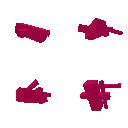

In [136]:
# how do some example look across batches though?

x_ = jnp.stack([
    x[0][0], 
    x[0][1],
    x[1][4],
    x[1][5]
])

pil_imgs = list(map(to_pil_img, x_))
collage(pil_imgs, 2, 2)


In [137]:
# pretty good! the off diagonals are > 0.9
# so it's generalising across the batch
embeddings, _ = embedding_model.stateless_call(params, nt_params, x_, training=False)
print(jnp.around(jnp.dot(embeddings, embeddings.T), 2))

[[1.         0.96999997 0.94       0.93      ]
 [0.96999997 1.         0.90999997 0.91999996]
 [0.94       0.90999997 1.         0.96999997]
 [0.93       0.91999996 0.96999997 1.        ]]
